In [1]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from torch.utils.data import Dataset, DataLoader

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [15]:
# Load small MNIST dataset using sklearn.datasets.load_digits. 
mnist = load_digits()

X, y = mnist.images, mnist.target

# Convert y to be one-hot encoded (this is important for classification!)
y = LabelBinarizer().fit_transform(load_digits().target)
# Add channel dimension to X
X = X[..., np.newaxis]

# Split up the dataset into train and test sets with a reasonable amount of test samples. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

# Convert numpy arrays to torch tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test  = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test  = torch.from_numpy(y_test.astype(np.float32))

X_train = torch.permute(X_train, dims=(0, 3, 1, 2))
X_test  = torch.permute(X_test, dims=(0, 3, 1, 2))

print("X_train: {} samples ({}), {} x {} x {}".format(X_train.shape[0], X_train.dtype, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
print("X_test:  {}  samples ({}), {} x {} x {}".format(X_test.shape[0], X_test.dtype, X_test.shape[1], X_test.shape[2], X_test.shape[3]))

# Plot some sample images


X_train: 1437 samples (torch.float32), 1 x 8 x 8
X_test:  360  samples (torch.float32), 1 x 8 x 8


In [41]:
def evaluate(X_test, y_test):
    # Evaluate the model using the test set
    classifier.eval()
    correct = 0
    eval_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for X, y in zip(X_test, y_test):
            # Unpack batch dimensions
            X = X.unsqueeze(0)
            y = y.unsqueeze(0)
            # Calculate outputs by running images through the network
            y_pred = classifier(X)
            loss = critereon(y_pred, y)
            # The predicted class label is the maximum prediction
            predicted = torch.argmax(y_pred, 1)
            true = torch.argmax(y, 1)
            correct += (predicted == true).sum().item()
            eval_loss += loss

    eval_loss /= X_test.shape[0]
    
    return eval_loss, correct


def plot_digits(X, nrows=8, ncols=8):
    fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    ax = ax.flatten()
    height, width, _ = X[0].shape
    rndm_idx = np.random.choice(X.shape[0], nrows * ncols)
    
    for i in range(nrows * ncols):
        image = np.reshape(X[rndm_idx[i]], (height, width))
        ax[i].imshow(image, cmap='gray_r')

# plot loss history
def plot_history(train_history, test_history=None, ylabel=""):
    plt.figure(figsize=(10, 6))

    train_history = np.array(train_history)
    plt.plot(train_history[:, 0], train_history[:, 1])
    
    if test_history:
        test_history = np.array(test_history)
        plt.plot(test_history[:, 0], test_history[:, 1])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.show()

In [16]:
class myCNN(nn.Module):
    def __init__(self, in_channels=1, n_conv=8, n_filters=128, n_classes=10, kernel_size=(3, 3)):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=n_conv, kernel_size=kernel_size, padding=2) #  (n + 2p − f + 1) = 10x10
        self.pool = nn.MaxPool2d(2,2) # 8 Filter 5x5
        self.conv2 = nn.Conv2d(in_channels=n_conv,out_channels=2*n_conv, kernel_size=3,padding=2) # (7x7)

        self.fc1 = nn.Linear(in_features=2*n_conv*kernel_size[0]*kernel_size[0], out_features=n_filters)
        self.fc2 = nn.Linear(in_features=n_filters, out_features= n_filters// 2)
        self.fc3 = nn.Linear(n_filters//2,10)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions (except batch)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1) # As we are classifying multiple classes we use softmax
        
        return x
        

In [26]:
# Define hyperparameters
n_epochs = 100
n_classes = 10
n_conv = 16
n_filters = 184
learning_rate = 5e-1

In [31]:
# define Net
classifier = myCNN(n_conv=n_conv,n_filters=n_filters)

In [32]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(),lr=learning_rate)

In [35]:
# Check initial loss. As we expect a diffuse probability of 0.1 for each class (since there are 10 classes), 
# and Softmax loss is the negative log probability of the correct class so: -ln(0.1) = 2.302
print(f"Initial accuracy: {1/10} | Initial lr: {learning_rate} | Initial softmax loss: {-np.log(1/10):.3f}")
print()

# Evaluate the classification model on testset 
evaluate(X_test, y_test)

# Train the model using the training set
classifier.train()
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(0, n_epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward pass
    y_pred = classifier(X_train)
    # calculate loss
    loss = critereon(y_train, y_pred)

    # Backward pass
    loss.backward()
    # Optimize
    optimizer.step()

    # Track and log losses  
    train_loss_history.append((epoch, loss.item()))
    if (epoch + 1) % 10 == 0:
        test_loss, correct = evaluate(X_test, y_test)
        test_loss_history.append((epoch, test_loss.item()))
        test_accuracy = 100 * correct / X_test.shape[0]
        test_accuracy_history.append((epoch, test_accuracy))
        print(f'Epoch: {epoch + 1:4} / {n_epochs} | train loss: {loss:.3f} | Test loss: {test_loss:.3f} Test accuracy: {test_accuracy:.2f} %', end='\r')

print(), print()
# Evaluate the classification model on testset 
loss, correct = evaluate(X_test, y_test)
print(f'Test loss: {loss:.3f} Test accuracy: {100 * correct / X_test.shape[0]} %')

Initial accuracy: 0.1 | Initial lr: 0.5 | Initial softmax loss: 2.303

Epoch:  100 / 100 | train loss: 2.360 | Test loss: 2.364 Test accuracy: 9.72 %%

Test loss: 2.364 Test accuracy: 9.722222222222221 %


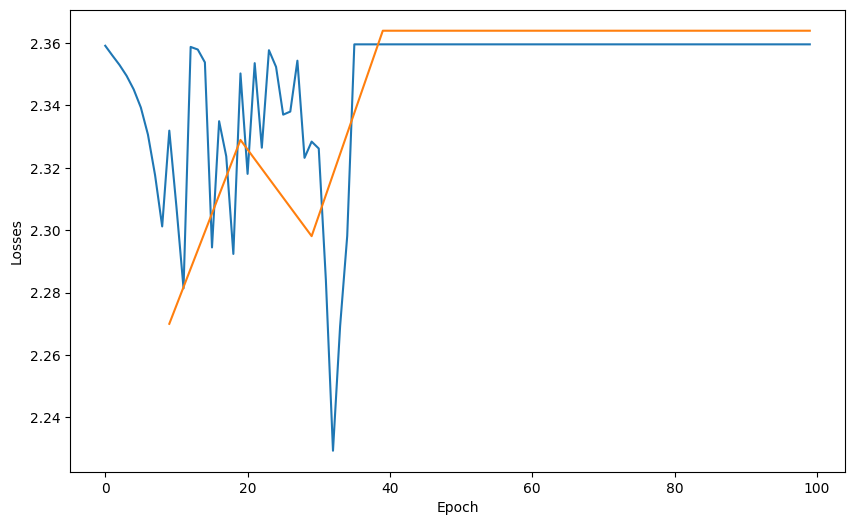

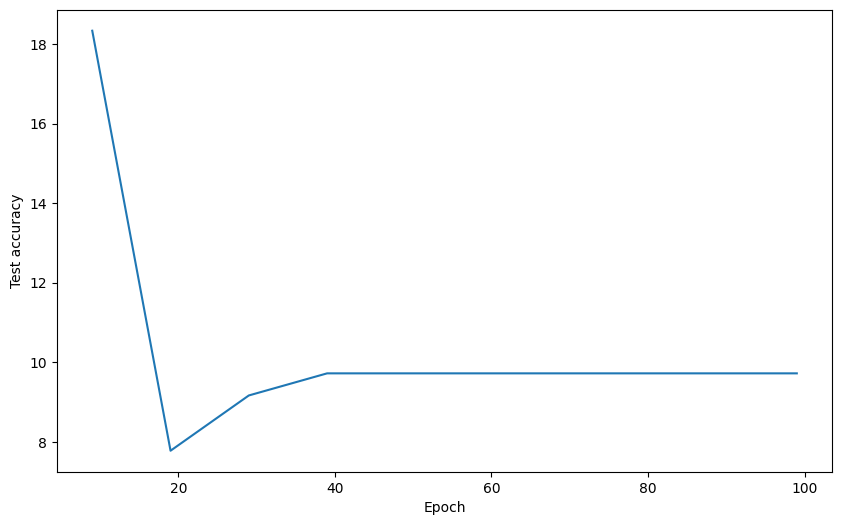

In [40]:
# Plot loss history over epochs
plot_history(train_loss_history, test_loss_history, ylabel="Losses")
plot_history(test_accuracy_history, ylabel="Test accuracy")